# Exploring Quantitative Stability in All Samples

- **License:** [MIT License](https://opensource.org/licenses/MIT)
- **Version:** 0.2
- **Edit Log:** 
    - 2024-01-19: Initial version of the notebook
    - 2024-02-21: Revised the notes 

**Data Information:**

The data used here comes from the previous notebook where the `questvar` frame has been run over all cancer cell line pairs (around 64K pairs). The resulting data are saved in multiple different formats to facilitate easy handling and gives more opportunity to display different results with different questions. The data is saved in the `data/results/` folder. The shared summary table (`shared_proteins_all_pairs.feather`) will be the main data used to explore the quantitative stability and variability in all cancer cell lines. 

**Notebook Summary:**

This notebook is the continuation of the previous notebook where the `questvar` frame has been run over all cancer cell line pairs. The goal of this notebook is to explore the quantitative stability in all cancer cell lines. The notebook is divided into three sections. In the first section, I will explore the quantitatively stable and variable proteins in majority of cancer cell pairs. Second part will be looking at the protein intensity level comparison of those identified over all cancer cell lines grouped by their system of origin. In the last section, I will be running the `g:Profiler` api on the quantitatively stable and variable proteins to highlight the enriched pathways in KEGG and REACTOME databases. This will allow me to see what biological processes or pathways stays stable in cancer cell line space and what pathways tend to vary a lot.

## Setup Notebook

This part is a standard for my notebooks, where I import the all used libraries, set the design of the notebook, and define the paths for data and figures. 

> **Note:** The HTML rendering of this notebook will not show the code cells by default, but the code can be visible by clicking the "code" buttons aligned on the right.

### Libraries Used

In [1]:
import os
import sys
import feather
import warnings

import numpy as np 
import pandas as pd

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
import matplotlib.ticker as mtick # Format tick labels
from matplotlib import patches

from upsetplot import from_contents, plot # Specialized Plotting for Set-Related Data
import PyComplexHeatmap as pch # Complex Heatmaps in Python

sys.path.append('../')
# Custom functions
from questvar import utils, enrich, plots 
warnings.filterwarnings('ignore')
nbStartTime = utils.getTime()

### Notebook's Styling

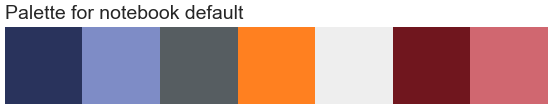

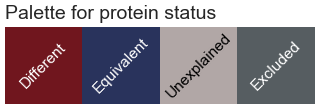

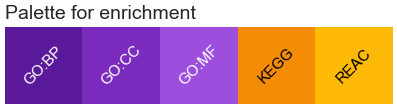

In [2]:
### Notebook Configuration
## Colors
def_colors = ["#29335c","#7e8cc6","#565d61","#ff8020","#eeeeee","#70161e","#d06770"]

# Color dict for the protein status
status_colors = {
    "Different": "#70161e",
    "Equivalent": "#29335c",
    "Unexplained": "#b1a7a6",
    "Excluded": "#565d61"
}
# Color dict for enrichment
enrichment_palette = {
    "GO:BP": "#5a189a",
    "GO:CC": "#7b2cbf",
    "GO:MF": "#9d4edd",
    "KEGG":  "#f48c06",
    "REAC":  "#ffba08"
}

## Configure some general styling
# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300


## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

## Color Palettes used
# Default colors
plots.color_palette(
    def_colors,
    name = "notebook default"
)

# Protein status colors
plots.color_palette(
    status_colors,
    name = "protein status",
)

# Enrichment colors
plots.color_palette(
    enrichment_palette,
    name = "enrichment"
)

### Data and Result Paths

The data and figure related paths are defined here. It will point to the input file paths as well as notebook specific output paths to distinguish between similar application result related notebooks. The `notebook_name` variable contains the specific identifier that will be used to create the output folder for this notebook. For the output the data `data/results/{notebook_name}/` will be used and for the figures `figures/{notebook_name}/` will be used.

Similar to other notebooks the notebook's figure path will contain subfolders specific to the formats user selected to save the figures in for instance if `['png', 'pdf']` is selected then there will be two subfolders `png` and `pdf` in the `figures/{notebook_name}/` saving the figures in png and pdf formats respectively.

In [3]:
# Establish the paths

notebook_name = "InAllSamples"                  # Notebook name

data_path = "./data/"                           # Main data folder
fig_path = f"./figures/{notebook_name}/"        # Figures folder
proces_path = f"{data_path}processed/"
input_path = f"{data_path}results/"
output_path = f"{data_path}results/{notebook_name}/"
supp_path = f"{data_path}supplementary/"        # Supplementary data folder (for Manuscript)


# Check if the paths exist
if not os.path.exists(input_path):
    raise ValueError(
        f"the input folder doesn't exists, run the notebook '02-Create_Input_and_Run_Tests.ipynb' first"
    )

# Create folders for various outputs
for i in [output_path]:
    if not os.path.exists(i):
        os.makedirs(i)   

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = fig_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

## Setup the Data

Opening and setting up the data that will be used in the notebook, produced in the previous notebook.


### Diagram of the Boundaries Used in Testing Previous Notebook

This is a small addition to create a simple diagram highlighting the equivalence and different log2 fold-change boundaries used in the previous notebook when QuEStVar run its test with on all cell line combinations. 

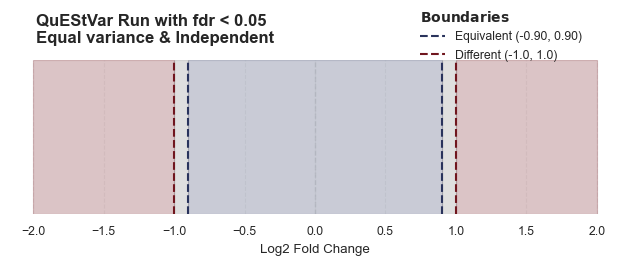

In [4]:
# Create a simple graph showing equivalence and difference boundaries
# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 2),
)

# Plot the data
# No data is plotted, only the lines are drawn
sns.scatterplot(
    x=[-2, 2],
    y=[0, 1],
    color=def_colors[2],
    ax=ax,
    s=0,
    legend=False,
    rasterized=True
)

# Draw 0 line with light gray
ax.axvline(
    0,
    color="lightgray",
    linestyle='--',
    linewidth=1.0,
    zorder=0,
    alpha=0.5

)

# Draw lines at -.81 and .81 with def_color[0]
ax.axvline(
    -0.90,
    color=def_colors[0],
    linestyle='--',
    linewidth=1.5
)
ax.axvline(
    0.90,
    color=def_colors[0],
    linestyle='--',
    linewidth=1.5
)
# Draw rectangle between -.81 and .81 with def_color[1] and alpha=0.5
# This should span the whole y-axis
ax.axvspan(
    -0.90, 0.90,
    color=def_colors[0],
    alpha=0.25
)

# Draw lines at -1 and 1 with def_color[-2]
ax.axvline(
    -1,
    color=def_colors[-2],
    linestyle='--',
    linewidth=1.5
)
ax.axvline(
    1,
    color=def_colors[-2],
    linestyle='--',
    linewidth=1.5
)

# Draw rectangle from -2 to -1 with def_color[-1] and alpha=0.5
# This should span the whole y-axis
ax.axvspan(
    -2, -1,
    color=def_colors[-2],
    alpha=0.25
)

# Draw rectangle from 1 to 2 with def_color[-1] and alpha=0.5
# This should span the whole y-axis
ax.axvspan(
    1, 2,
    color=def_colors[-2],
    alpha=0.25
)

# Draw rectangle between -1 to -.81 with lightgrey and alpha=0.5
# This should span the whole y-axis
ax.axvspan(
    -1, -0.90,
    color="gray",
    alpha=0.25
)

# Draw rectangle between .81 to 1 with lightgrey and alpha=0.5
# This should span the whole y-axis
ax.axvspan(
    0.90, 1,
    color="gray",
    alpha=0.25
)

# Set x-labels
ax.set_xlabel("Log2 Fold Change")
# Set y-labels
# ax.set_ylabel("Relative Abundance")

# Remove y-axis
ax.set_yticks([])
# Set x-limits

# Add grid
ax.grid(
    which='major', 
    color='lightgray', 
    linestyle='--', 
    alpha=0.25
)

# Add title
ax.set_title(
    "QuEStVar Run with fdr < 0.05\nEqual variance & Independent",
    fontsize=12,
    fontweight="bold",
    pad=12.5,
    loc="left", 
    x=0.05,
)

# Create line legend handles using line objects
from matplotlib.lines import Line2D
handles = [
    Line2D(
        [0], [0], 
        color=status_colors["Equivalent"], 
        linestyle="--",
        linewidth=1.5,
        label="Equivalent (-0.90, 0.90)"
    ),
    Line2D(
        [0], [0], 
        color=status_colors["Different"], 
        linestyle="--",
        linewidth=1.5,
        label="Different (-1.0, 1.0)"
    ),
]


# Add legend
ax.legend(
    handles=handles,
    frameon=False,
    # Set to top with 3 columns
    loc="upper center",
    ncol=1,
    bbox_to_anchor=(.8, 1.4),
    # Set the title
    title="$\\bf{Boundaries}$",
    # Set the title fontsize
    title_fontsize=10,
)._legend_box.align = "left"


sns.despine(
    left=True,
    bottom=True
)

# plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "ProteinStatusBoundaries",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )


This diagram simply highlights the log2 fold-change necessary at the least to be considered equivalent or different assuming the adjusted p-value is less than user set threshold (in the case of our testing in previous notebook 0.05). Additionally I highlight the areas that represented for the consideration for equivalence and difference based on the boundaries, light red area is place where protein can't be equivalent, and light blue area is the place where protein can't be different. In between light gray area is the place where protein can't be either equivalent or different and only unexplained because of the nature of the boundaries set.

### Read the Metadata

The metadata used for cell line sample information is read from the `data/processed/metadata.feather` file.

In [5]:
metadata = feather.read_dataframe(
    f"{proces_path}metadata.feather"
)
print(f"Data Shape: {metadata.shape}")
metadata.head()

Data Shape: (360, 10)


,SIDM,Cell_line,System_name,Tissue_type,Cancer_type,Cancer_subtype,Collection_site,Status,Age,Sex
0,SIDM00872,HCC1954,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
1,SIDM00875,HCC1806,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
2,SIDM00879,HCC1500,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
3,SIDM00629,MDA-MB-436,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Pleural_effusion,Metastatic,Adult,Female
4,SIDM00122,BT-549,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Breast,Primary,Adult,Female


### Expanded Protein Information Data

The expanded protein information data is read from the `data/processed/protein_expanded_data.feather`, which contains the protein information, with mean, cv, and rank columns, as well as the average protein intensity values for each cell line.

In [6]:
protein_data = feather.read_dataframe(
    f"{input_path}protein_expanded_data.feather"
)

# Get the unique proteins
allProteins = protein_data["entry"].unique()

print(f"Data Shape: {protein_data.shape}")
protein_data.head()

Data Shape: (7975, 367)


,entry,entryName,proteinDescription,geneName,Mean,Rank,CV,SIDM00018,SIDM00023,SIDM00043,SIDM00045,SIDM00050,...,SIDM01178,SIDM01183,SIDM01186,SIDM01187,SIDM01191,SIDM01194,SIDM01196,SIDM01203,SIDM01206,SIDM01219,SIDM01247,SIDM01248
0,Q9Y651,SOX21_HUMAN,Transcription factor SOX-21,SOX21,2.6725,5215.0000,34.3192,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6178,NaN,NaN,NaN
1,P37108,SRP14_HUMAN,ignal recognition particle 14 kDa protein,SRP14,6.5487,423.0000,39.5648,137.3901,110.0761,107.8404,73.9405,63.5611,...,66.4011,94.4678,144.4451,90.0577,62.1151,70.5387,68.0420,43.2385,116.7107,227.9230,130.3740,80.4335
2,Q96JP5,ZFP91_HUMAN,E3 ubiquitin-protein ligase ZFP91,ZFP91,3.5780,3040.0000,30.8813,12.4335,19.3804,20.5577,8.6273,15.3369,...,14.0515,11.1489,12.7769,NaN,16.2813,10.3848,NaN,4.2041,9.3307,9.3485,12.5094,31.3789
3,Q9Y4H2,IRS2_HUMAN,Insulin receptor substrate 2,IRS2,2.3271,6163.0000,66.4872,NaN,5.1058,NaN,NaN,NaN,...,NaN,4.2346,NaN,NaN,NaN,0.7251,NaN,3.1175,NaN,NaN,NaN,NaN
4,P36578,RL4_HUMAN,Large ribosomal subunit protein uL4,RPL4,7.5242,197.0000,30.6928,242.9197,210.8121,173.7156,299.7880,239.7711,...,246.7877,148.8203,146.9704,176.2236,213.4566,180.7671,198.1770,282.6860,187.0721,253.5591,148.1466,204.8152


### Protein Specific Summary Table

The protein specific summary table is read from the `data/results/shared_proteins_all_pairs.feather` file. This table contains the summary of how many of the cell line pairs individual proteins were identified as equivalent, different, or unexplained. Additionally, it contains the `%tested` and `%(EQ-DF)` (RSM) columns that are used to find out quantitatively stable and variable proteins across all cell line pairs.

This will be the primary source of the analysis in this notebook since I will be focusing on the exploration of stable and variable proteins and their biological relevance. 

In [7]:
# Shared summary = Protein's Status on percentage of pairs
shared_summary = feather.read_dataframe(input_path+"shared_proteins_all_pairs.feather")

# Print shape and head
print("Shared Summary Shape:", shared_summary.shape)
shared_summary.head()

Shared Summary Shape: (7975, 12)


,Protein,Mean,Rank,CV,Df,Eq,tested,%Df,%Eq,%tested,(Eq-Df),%(EQ-DF)
0,Q9Y651,2.7584,5516.0000,34.3192,2.0000,14.0000,66.0000,3.0303,21.2121,0.1021,12.0000,18.1818
1,P37108,6.6636,469.0000,39.5648,18401.0000,29907.0000,64620.0000,28.4757,46.2813,100.0000,11506.0000,17.8056
2,Q96JP5,3.5944,3567.0000,30.8813,3811.0000,17964.0000,46360.0000,8.2204,38.7489,71.7425,14153.0000,30.5285
3,Q9Y4H2,2.6583,5780.0000,66.4872,279.0000,186.0000,1128.0000,24.7340,16.4894,1.7456,-93.0000,-8.2447
4,P36578,7.5300,252.0000,30.6928,13584.0000,23405.0000,64620.0000,21.0214,36.2194,100.0000,9821.0000,15.1981


# Exploring the Stability and Variability within Cancer Cell Line - Proteomics Data

## Identifying Most Quantitatively Stable and Variable Proteins

Using the shared summary table for each protein that contains `%tested` and `%(EQ-DF)` (RSM) columns, I can identify the quantitatively stable and variable proteins that fit my criteria.

- **Quantitatively Stable Proteins:** Proteins that are tested in at least 95% of the cell line pairs and its RSM score is more than 35.
- **Quantitatively Variable Proteins:** Proteins that are tested in at least 95% of the cell line pairs and its RSM score is less than -35.

> **Note 1:** The RSM (Relative Stability Metric) score is calculated as the difference between the percentage of cell line pairs where the protein is identified as equivalent and the percentage of cell line pairs where the protein is identified as different. The RSM score establishes the tendency of a given protein to be stable or variable for all or subset of the comparisons.

> **Note 2:** The 95% testing threshold is used to make sure that the protein is tested in majority of the cell line pairs and not just a few to establish. Since a protein can be tested in one and being equivalent or different doesn't make it stable or variable for all or subset of comparisons.

In [8]:
# Find Mostly Variable and Mostly Stable Proteins
# Criterias when selecting proteins
stability_cutoff = 35
tested_cutoff = 95
variability_cutoff = -35
print(f"Protein must be tested at least {tested_cutoff}% of comparisons (n~= {round(tested_cutoff*(shared_summary['tested'].max())/100)}) to be considered")
print("For stability, RSM >=", stability_cutoff)
print("For variability, RSM <=", variability_cutoff)

most_variable_proteins = shared_summary[(
    (shared_summary["%(EQ-DF)"] < variability_cutoff) &
    (shared_summary["%tested"] > tested_cutoff)
)]["Protein"].tolist()

# Mostly Stable Proteins
most_stable_proteins = shared_summary[(
    (shared_summary["%(EQ-DF)"] > stability_cutoff) &
    (shared_summary["%tested"] > tested_cutoff)                           
)]["Protein"].tolist()
print()
print("Based on the criteria")
print("Most Variable Proteins:", len(most_variable_proteins))
print("Most Stable Proteins:", len(most_stable_proteins))

Protein must be tested at least 95% of comparisons (n~= 61389) to be considered
For stability, RSM >= 35
For variability, RSM <= -35

Based on the criteria
Most Variable Proteins: 26
Most Stable Proteins: 171


Using the criteria above, there are 26 proteins shown tendency to be quantitatively variable, where 171 are shown tendency to be quantitatively stable.

With a scatter plot I can visualize the distribution of the proteins based on their `%tested` and `%(EQ-DF)` (RSM) values. And highlight the criterias on the plot. Scatter plot uses the annotation as hue variable indicating stable proteins as dark blue and variable proteins as dark red, while the rest "undetermined" proteins are shown as light gray with added alpha. X-axis represents the `RSM` scores while the y-axis represents the `%tested` values. To highlight the criterias used to identify the stable and variable proteins, I added vertical and horizontal lines to the plot. The vertical line represents the 95% testing threshold and the horizontal line represents the RSM score threshold of 35.

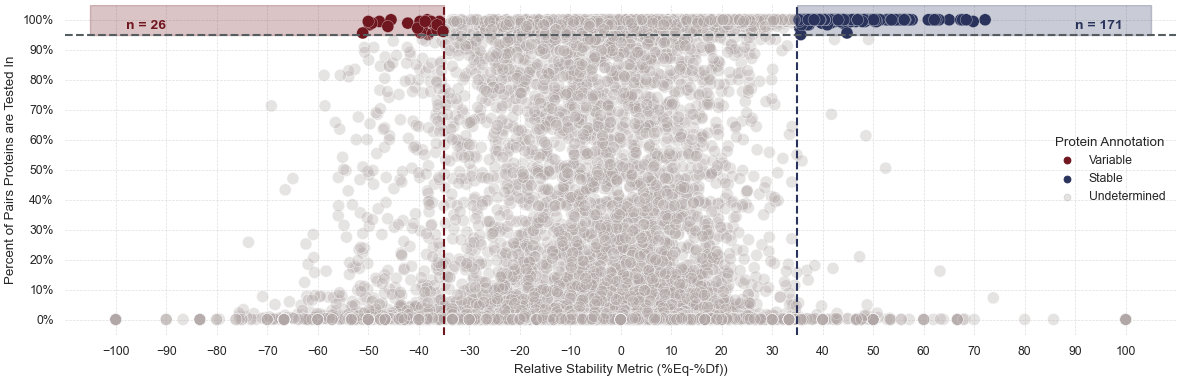

In [9]:
# Create the annotated shared summary
plot_data = shared_summary[[
    "Protein", 
    "%Eq",
    "%Df",
    "%(EQ-DF)", 
    "%tested",
    "Mean",
    "Rank",
    "CV"
]].set_index("Protein").copy()

plot_data["Annotation"] = "Undetermined"
plot_data.loc[
    most_variable_proteins,
    "Annotation"
] = "Variable"
plot_data.loc[
    most_stable_proteins,
    "Annotation"
] = "Stable"

# Order Annotation to be Stable, Variable, Undetermined
plot_data["Annotation"] = pd.Categorical(
    plot_data["Annotation"],
    categories=["Variable", "Stable", "Undetermined"],
    ordered=True
)

# Write the shared_summary with annotation to table_s2_5.csv
annotated_data = protein_data[[
    "entry", 
    "entryName", 
    "proteinDescription", 
    "geneName"
]].set_index("entry").join(
    plot_data
).sort_index()

annotated_data.to_csv(
    f"{supp_path}table_s2_5.csv"
)

# Plot the Scatterplot of Relative Stability vs. Percent Tested
# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(12, 4),
    # sharex=True,
    # sharey=True
)

sns.scatterplot(
    data=plot_data,
    y="%tested",
    x="%(EQ-DF)",
    hue="Annotation",
    palette={
        "Undetermined": status_colors["Unexplained"]+"50",
        "Variable": status_colors["Different"],
        "Stable": status_colors["Equivalent"]
    },
    edgecolor='white',
    linewidth=0.25,
    rasterized=True, 
    ax=ax,
    s=75
    
)

# Add Styling to the plot
ax.set_ylabel("Percent of Pairs Proteins are Tested In")
ax.set_xlabel("Relative Stability Metric (%Eq-%Df))")
# ax.set_title("Visualizing the Selection of the Most Stable Proteins")
# ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Make the x-ticks go from -100 to 100 with 20 intervals
ax.set_xticks(np.arange(-100, 110, 10))
# Make the y-ticks go from 0 to 100 with 1 intervals
ax.set_yticks(np.arange(0, 105, 10))

ax.legend(
    frameon=False,
    title="Protein Annotation",
)

# Draw a rectangle for the stable proteins
rect_stb = patches.Rectangle(
    (stability_cutoff, tested_cutoff),  # (x,y) <- Thresholds
    (105-stability_cutoff), # width 
    (105-tested_cutoff),    # height
    linewidth=1,
    edgecolor=def_colors[0],
    facecolor=def_colors[0],
    alpha=0.25
)
# Draw a rectangle for the variable proteins
rect_var = patches.Rectangle(
    (variability_cutoff, tested_cutoff),    # (x,y) <- Thresholds
    (-105-variability_cutoff),              # width
    (105-tested_cutoff),                    # height
    linewidth=1,
    edgecolor=def_colors[-2],
    facecolor=def_colors[-2],
    alpha=0.25
)
ax.add_patch(rect_stb)
ax.add_patch(rect_var)
# Draw lines at cutoffs
ax.axvline(
    stability_cutoff,
    color=def_colors[0], 
    linestyle='--', 
    linewidth=1.5
)
ax.axvline(
    variability_cutoff,
    color=def_colors[-2],
    linestyle='--',
    linewidth=1.5
)
ax.axhline(
    tested_cutoff, 
    color=def_colors[2], 
    linestyle='--', 
    linewidth=1.5
)

# Add the number of proteins in each rectangle
ax.text(
    90,
    tested_cutoff+1,
    "n = "+str(len(most_stable_proteins)),
    color=def_colors[0],
    weight="bold",
    ha="left",
    va="bottom", 
    fontsize=10
)
ax.text(
    -90,
    tested_cutoff+1,
    "n = "+str(len(most_variable_proteins)),
    color=def_colors[-2],
    weight="bold",
    ha="right",
    va="bottom",
    fontsize=10
)

# set grids on x and y
ax.grid(
    axis="both",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.75
)

sns.despine(
    left=True,
    bottom=True
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "ProteinStabilitySelection_ScatterWithShades",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

### Plot the Stable and Variable Proteins on the Protein-Rank Plot

To display the overall standing of the annotated proteins in the dataset I've created a protein-rank plot wi the protein annotation as hue variable. The plot shows the distribution of the proteins based on their mean intensity in log2 scale and rank calculated from the mean with protein annotation indicating if the protein is identified as stable, variable or undertermined. The proteins are ranked based on their mean protein intensity values across all cell lines. The proteins that are quantitatively stable are shown as dark blue, quantitatively variable proteins are shown as dark red, and the rest of the proteins are shown as light gray with added alpha.

Additionally to highlight the density and the distribution of the proteins I've added boxplots with annotation hue variable as the x and y marginal plots. The marginal plots are showing the distribution of the proteins based on their mean intensity values and rank values. The marginal plots are using the same annotation as the main plot to highlight the distribution of the proteins based on their stability.

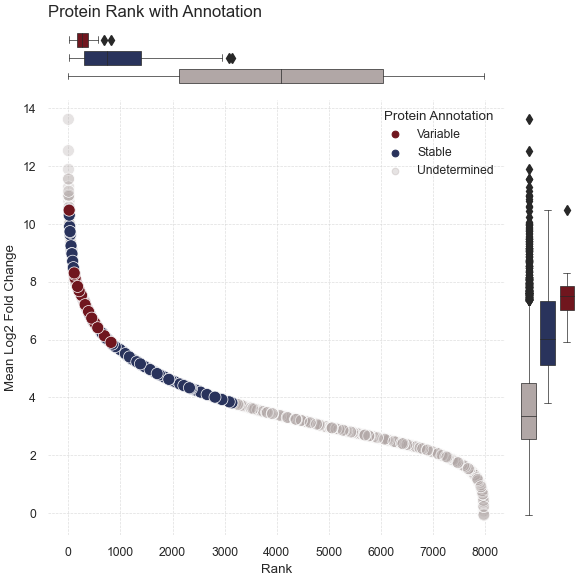

In [10]:
# Setup a figure layout for main plot with x and y marginal plots for the boxplot
# Top plot is the x-axis marginal boxplot use 0.1 height and both columns
# Right plot is the y-axis marginal boxplot use 0.1 width and both rows
# Main plot uses 0.8 height and 0.8 width and both rows and columns

# Initialize the figure with a 2x2 grid
fig = plt.figure(
    figsize=(6, 6),
    constrained_layout=True
)
gs = fig.add_gridspec(
    2, 2,
    height_ratios=[0.1, 0.8],
    width_ratios=[0.8, 0.1],
)
ax_main = fig.add_subplot(gs[1, 0])
ax_xhist = fig.add_subplot(gs[0, 0])
ax_yhist = fig.add_subplot(gs[1, 1])


# Add Main Plot
sns.scatterplot(
    ax=ax_main,
    data=plot_data.sort_values(by="Annotation", ascending=False),
    x="Rank",
    y="Mean",
    hue="Annotation",
    palette={
        "Undetermined": status_colors["Unexplained"]+"50",
        "Variable": status_colors["Different"],
        "Stable": status_colors["Equivalent"]
    },
    s=75,
    edgecolor="white",
    linewidth=0.5,
    rasterized=True
)

# Add Styling to the plot
ax_main.set_ylabel("Mean Log2 Fold Change")
ax_main.set_xlabel("Rank")

# Add x-axis marginal plot
sns.boxplot(
    ax=ax_xhist,
    data=plot_data,
    x="Rank",
    y="Annotation",
    hue="Annotation",
    dodge=False,
    palette={
        "Undetermined": status_colors["Unexplained"]+"50",
        "Variable": status_colors["Different"],
        "Stable": status_colors["Equivalent"]
    },
    saturation=1,
    width=0.75,
    linewidth=0.5,
    # legend=False,
)

# Remove all elements from the boxplot
ax_xhist.get_legend().remove()
ax_xhist.set_xlabel("")
ax_xhist.set_ylabel("")
ax_xhist.set_yticks([])
ax_xhist.set_xticks([])
ax_xhist.set_title(
    "Protein Rank with Annotation",
    fontsize=12,
    loc="left",
    pad=10.0
)

# Add y-axis marginal plot
sns.boxplot(
    ax=ax_yhist,
    data=plot_data,
    y="Mean",
    x="Annotation",
    hue="Annotation",
    dodge=False,
    palette={
        "Undetermined": status_colors["Unexplained"]+"50",
        "Variable": status_colors["Different"],
        "Stable": status_colors["Equivalent"]
    },
    saturation=1,
    width=0.75,
    linewidth=0.5,
    # legend=False,
)

# Remove all elements from the boxplot
ax_yhist.get_legend().remove()
ax_yhist.set_xlabel("")
ax_yhist.set_ylabel("")
ax_yhist.set_yticks([])
ax_yhist.set_xticks([])
ax_yhist.set_title("")
ax_yhist.invert_xaxis()

# set grids on x and y
ax_main.grid(
    axis="both",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.75
)

ax_main.legend(
    frameon=False,
    title="Protein Annotation",
)

sns.despine(
    left=True,
    bottom=True
)

plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "StableVariableProteins_on_Mean_ProteinRankPlot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

Undermined proteins are identified regardless of their rank, but the stable variable proteins are mostly has been identified in higher ranks the lowest a stable protein goes is around 3000th rank. Because the plot doesn't have any jitter on x or y axis, I've put the variable and stable proteins on top of the undetermined proteins to highlight their distribution, but there are still some undetermined proteins in the regions where stable and variable proteins are identified, which can be seen in the marginal plots.

## Hierarchical Clustering of the Quantitatively Stable and Variable Proteins

### Looking at Variable Only Subset

To see if there are any discerable patterns in the quantitatively variable proteins, I will look at them in a subsetted hierarchical clustering and heatmap. The data is scaled with z-score row-wise (protein) with missing values are replaced with 0 since hierarchical clustering requires a complete data. I've also replaced the protein accession ids with gene names to make the heatmaps more readable.

> **Note:** The missing values can happen even though very rare since our criteria for quantitative variability included a protein to be tested at least 95% of the times, there might be few cell lines a protein is not quantified. In that case the missing values are replaced with 0 to make the hierarchical clustering work.

In [11]:
# Create a protein to gene name mapper
id_col = "Protein"
name_col = "geneName"
index_mapper = annotated_data.loc[
    annotated_data["Annotation"] == "Variable", 
    [name_col]
].to_dict()[name_col]

# Subset for the variable proteins in averaged data
subset_data = np.log2(protein_data.set_index("entry").loc[
    list(index_mapper.keys()), 
    metadata["SIDM"]
])
# Replace the index with gene names
subset_data.index = subset_data.index.map(index_mapper)

# Protein-wise Z-score scaling 
plot_data = utils.scale_the_data(
    data=subset_data,
    axis=1,
    method="zscore"
).fillna(0)

print(f"Data Shape: {plot_data.shape}")
plot_data.head().iloc[:, :5]

Data Shape: (26, 360)


,SIDM00872,SIDM00875,SIDM00879,SIDM00629,SIDM00122
entry,,,,,
NHERF1,1.0641,0.4372,1.7275,-0.1710,-0.9460
FLNB,0.5554,0.5258,0.3673,1.2059,0.6182
IDH1,1.8934,-1.2831,-0.3892,-0.1459,-0.8077
CSTB,0.5189,-0.4577,0.0151,0.5641,1.4924
ITGB1,-0.1747,0.6595,0.1959,0.1959,1.2413


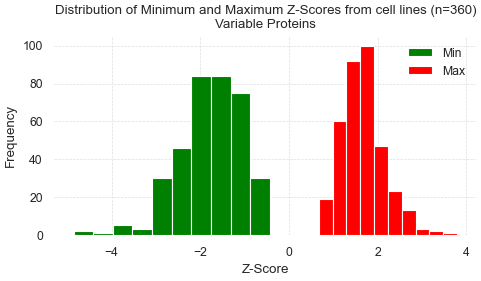

In [12]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5, 3),
)
plot_data.min().hist(color="green", label="Min")
plot_data.max().hist(color="red", label="Max")

ax.set_xlabel("Z-Score")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Minimum and Maximum Z-Scores from cell lines (n=360)\nVariable Proteins")
ax.legend(frameon=False)

ax.grid(
    axis="both",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.75
)

sns.despine(
    left=True,
    bottom=True
)

plt.tight_layout()

The previes of 5 row and ccolumns of the data after it is prepared for the heatmap. The heatmap is clustered using the `ward` linkage method and `euclidean` distance metric. THe first look heatmap is created with `PyComplexHeatmap` using -2 and 2 cbar limits to cover most of the spectrum without allowing outliers to mask majority of the data. The protein names are added as row names and cell line system origin is added as column coloring. To observe the heatmap I've created 2 column clusters from the hierarchical clsutering, and 4 row clusters. They represented as split within the heatmap. 

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 33.26833333333333 mm


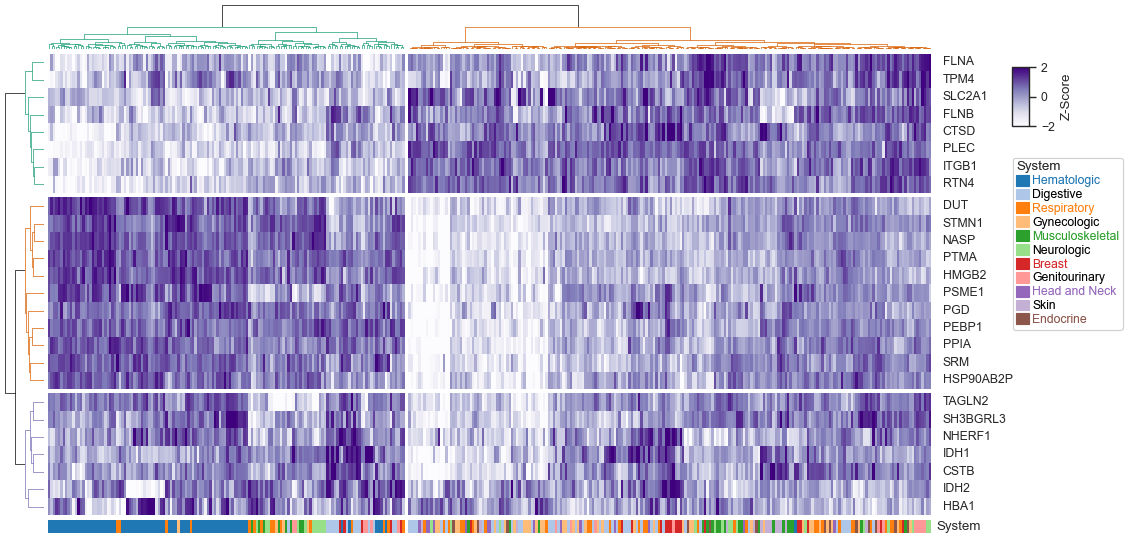

In [13]:
# Create the Clustermap (PyComplexHeatmap)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(12, 6),
)

col_ha = pch.HeatmapAnnotation(
    System=metadata[["SIDM", "System_name"]].set_index("SIDM"),
    axis=1,
)

res = pch.ClusterMapPlotter(
    data=plot_data,
    cmap="Purples",
    vmin=-2,
    vmax=2,

    # Row 
    row_cluster=True,
    row_cluster_method="ward",
    row_cluster_metric="euclidean",
    show_rownames=True,
    row_names_side='right',
    row_split=3,
    row_split_gap=1,
    row_dendrogram=True,

    # Column
    col_cluster=True,
    col_cluster_method="ward",
    col_cluster_metric="euclidean",
    show_colnames=False,
    col_split=2,
    col_split_gap=1,
    col_dendrogram=True,
    
    label="Z-Score",
    tree_kws={
        'row_cmap': 'Dark2',
        'col_cmap': 'Dark2',
    }, 
    bottom_annotation=col_ha,
);

At first glance two protein (row) clustersstands out, cluster starts with FLNA and cluster starts with DUT, seems to display an opposite pattern of column clusters, while the other ones is not as clear cut. Based on the cell line groupings in the column cluster 1 seems to be dominated by Hematologic system origin cell lines, while cluster 2 seems to be dominated by solid tissue system origin cell lines and almost no hematologic.

#### Cluster Contribution Pie Charts

To confirm this I wanted to create a cluster contribution pie charts for two column clusters indicating how much each system contributes to each cluster.

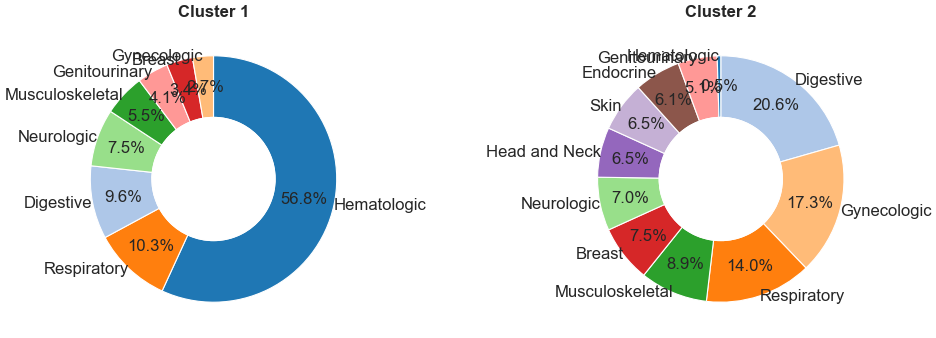

In [14]:
system_colors = col_ha.annotations[0].color_dict
sidm_system = metadata.set_index(["SIDM"])["System_name"].to_dict()
cluster_members = res.col_clusters

cluster_n = len(cluster_members.keys())
# Initialize a pie chart to show the system distribution per cluster
fig, ax = plt.subplots(
    nrows=1,
    ncols=cluster_n,
    figsize=(12, 4),
)

for i in range(cluster_n):
    # Get the cluster members
    members = pd.Series(cluster_members[i+1]).map(sidm_system).value_counts()
    # Plot the pie chart
    ax[i].pie(
        members,
        labels=members.index,
        colors=members.index.map(system_colors),
        autopct='%1.1f%%',
        pctdistance=0.75,
        labeldistance=1.,
        wedgeprops=dict(width=0.5),
        textprops=dict(fontsize=12),
        startangle=90,
        counterclock=False,
        normalize=True,
    )
    # Add title
    ax[i].set_title("Cluster "+str(i+1), fontsize=12, fontweight="bold")
    # Add circle to make it a donut chart
    ax[i].add_artist(plt.Circle((0,0), 0.5, color='white'))

# Save the figure
if save_to_folder: 
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "MostVariableProteins_ClusterPieCharts",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

The hematogoloc system (including cell lines from Myeloid and Lymphoid tissue) is dominant in cluster one with more than 56% of all the cell lines in that cluster, and only 0.5% in the cluster 2. While the some of the solid tissue cancer cell lines such as head and neck, endocrine, skin are only present in cluster 2. The cluster 2 is dominated by the solid tissue system origin cell lines with more than 99% of the cell lines in that cluster.

This is a quite and interesting split, this indicates that the quantitatively variable proteins are not only varying in their expression levels but also in their expression patterns across different cell line systems. To ensure what I am seeing between cluters is in-fact correct and to provide a list of proteins that drive this separation I will enhance the previous heatmap with column cluster differences in the average z-score values as an extension to rows with barplot. This bar plot will indicate the direction which cluster is higher or lower in average z-score values for each protein and by extension which protein clusters follow the trend. 

The heatmap is created with the same parameters as the previous heatmap, but with 3 row clusters. The row clusters are created with `ward` linkage method and `euclidean` distance metric. The row clusters are shown as split within the heatmap.

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 33.26833333333333 mm
Incresing ncol


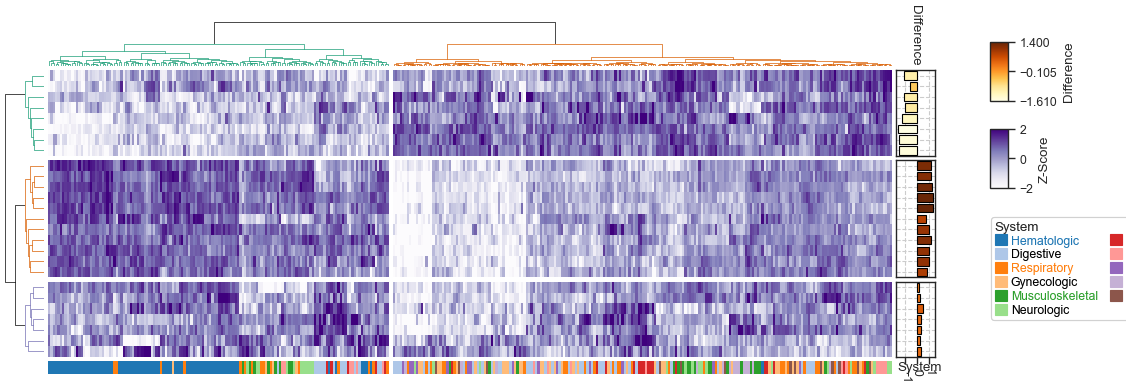

In [15]:
cluster_diff = (
    plot_data[cluster_members[1]].mean(axis=1) - 
    plot_data[cluster_members[2]].mean(axis=1)
)

# Create the Clustermap (PyComplexHeatmap)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(12, 4),
)

col_ha = pch.HeatmapAnnotation(
    System=metadata[["SIDM", "System_name"]].set_index("SIDM"),
    axis=1,
)

row_ha = pch.HeatmapAnnotation(
    Difference=pch.anno_barplot(
        cluster_diff,
        cmap="YlOrBr",
    ),
    axis=0,
)

res = pch.ClusterMapPlotter(
    data=plot_data,
    cmap="Purples",
    vmin=-2,
    vmax=2,

    # Row 
    row_cluster=True,
    row_cluster_method="ward",
    row_cluster_metric="euclidean",
    show_rownames=True,
    row_names_side='right',
    row_split=3,
    row_split_gap=1,
    row_dendrogram=True,
    # Column
    col_cluster=True,
    col_cluster_method="ward",
    col_cluster_metric="euclidean",
    show_colnames=False,
    col_split=2,
    col_split_gap=1,
    col_dendrogram=True,
    
    label="Z-Score",
    tree_kws={
        'row_cmap': 'Dark2',
        'col_cmap': 'Dark2',
    }, 
    bottom_annotation=col_ha,
    right_annotation=row_ha,
)

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "MostVariableProteins_CustomHeatmap",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

The difference of averaged z-score values between the column clusters are shown as barplots on the right side of the heatmap, this validates the observed behaviour, while the diffeerences are not stark since we are averaging it can still display the first two protein clusters are obviously separated by the column clusters and by extend the hematologic and solid tumors. 

The last protein cluster has slight overhead towards the cluster 1 but it is very small and can be neglected. 

This heatmap provides a reasoning the driving force behind what makes a protein quantitatively variable in our comparisons. Due to very large and very distinct comparisons, calling something variable for one particular reason is extremely hard. A protein can be differentially expressed when compared a breast cancer to a skin cancer, but that protein doesn't have to be differentially expressed when compared to a breast cancer to a lung cancer. This is why the quantitatively variable proteins are not only varying in their expression levels but also in their expression patterns across different cell line systems.

However one group is driving majority of the variability, which are hematologic cancers. I've observed that they have a distinct clustering in the data prep notebook as well as the original manuscript they mention hematologic cancers are more distinct than solid tissue cancers. This difference in select proteins (namely from cluster 1 and 2) is ultimately driven by the hematologic cancers, either have higher or lower expression levels in hematologic cancers compared to solid tissue cancers.

---

### Looking at Stable Only Subset

Observing differences with z-score from variable subset is easier since by definition there are distinct differences. However when I subset for only stable proteins this will be a lot less obvious. I am not saying stable set won't have any distinctness between cell lines, by our definition, they are stable in majority of the comparisons, but they can still have differences in their expression levels in some cell lines.

In [16]:
# Create a protein to gene name mapper
id_col = "Protein"
name_col = "geneName"
index_mapper = annotated_data.loc[
    annotated_data["Annotation"] == "Stable", 
    [name_col]
].to_dict()[name_col]

# Subset for the variable proteins in averaged data
subset_data = np.log2(protein_data.set_index("entry").loc[
    list(index_mapper.keys()), 
    metadata["SIDM"]
])
# Replace the index with gene names
subset_data.index = subset_data.index.map(index_mapper)

# Protein-wise Z-score scaling 
plot_data = utils.scale_the_data(
    data=subset_data,
    axis=1,
    method="zscore"
).fillna(0)

print(f"Data Shape: {plot_data.shape}")
plot_data.head().iloc[:, :5]

Data Shape: (171, 360)


,SIDM00872,SIDM00875,SIDM00879,SIDM00629,SIDM00122
entry,,,,,
SAP18,0.2981,0.8672,1.4749,-1.1855,-0.2851
PES1,-0.5169,0.8419,-0.7887,-0.1419,-0.6621
TCERG1,0.9636,0.0851,-1.4939,1.8389,1.3523
U2SURP,0.1310,1.0791,1.1435,-1.1811,-0.5924
POLR1C,0.2631,-0.2559,-2.5179,0.6004,0.9884


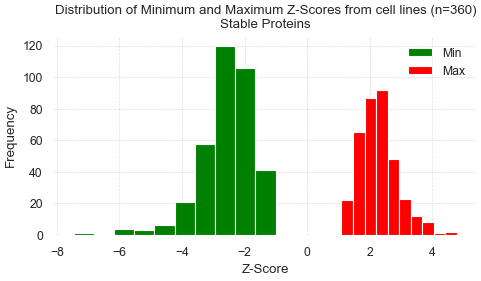

In [17]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5, 3),
)
plot_data.min().hist(color="green", label="Min")
plot_data.max().hist(color="red", label="Max")

ax.set_xlabel("Z-Score")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Minimum and Maximum Z-Scores from cell lines (n=360)\nStable Proteins")
ax.legend(frameon=False)

ax.grid(
    axis="both",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.75
)

sns.despine(
    left=True,
    bottom=True
)

plt.tight_layout()

I want to apply the same approach as I did for the variable subset, but I will be using the stable subset. I will be using the same parameters for the heatmap, but I will be using 3 row clusters and 5 column clusters. The row clusters are created with `ward` linkage method and `euclidean` distance metric. The row clusters are shown as split within the heatmap. Additionally I've added the RSM score as a bar plot for each protein represented as right side of the heatmap. The RSM score is calculated as the difference between the percentage of cell line pairs where the protein is identified as equivalent and the percentage of cell line pairs where the protein is identified as different. The RSM score establishes the tendency of a given protein to be stable or variable for all or subset of the comparisons. This is to indicate which proteins overall has higher score within the stable subset. 

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 33.26833333333333 mm


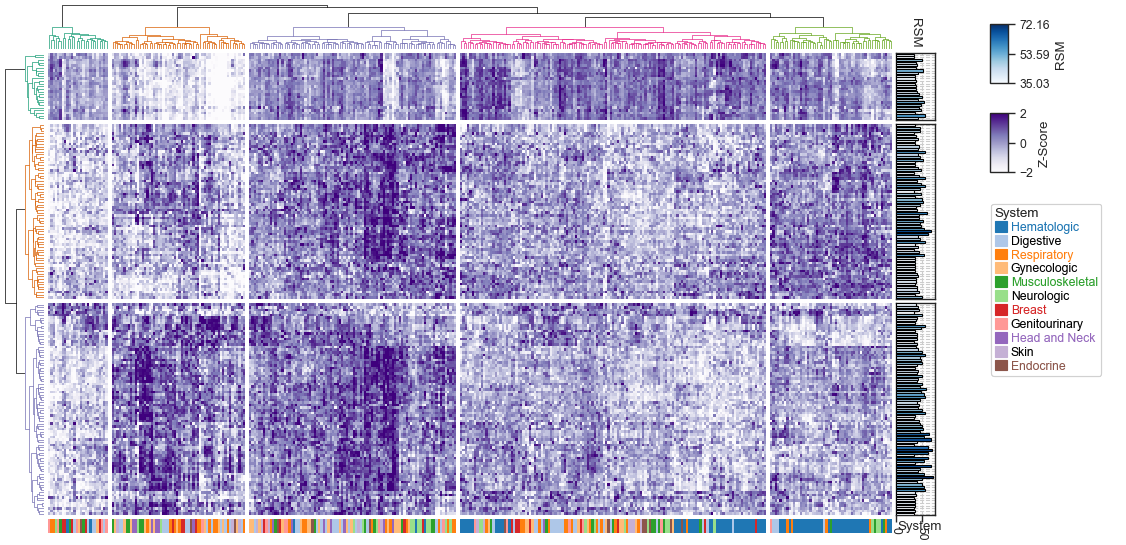

In [18]:
# Create the Clustermap (PyComplexHeatmap)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(12, 6),
)

row_annot = annotated_data.loc[
    annotated_data["geneName"].isin(plot_data.index),
    ["geneName", "%Eq", "%Df", "%(EQ-DF)"]
].set_index("geneName")

col_ha = pch.HeatmapAnnotation(
    System=metadata[["SIDM", "System_name"]].set_index("SIDM"),
    axis=1,
)

row_ha = pch.HeatmapAnnotation(
    RSM = pch.anno_barplot(
        row_annot["%(EQ-DF)"], 
        cmap="Blues",

    ),
    axis=0,
)


res = pch.ClusterMapPlotter(
    data=plot_data,
    cmap="Purples",
    vmin=-2,
    vmax=2,

    # Row 
    row_cluster=True,
    row_cluster_method="ward",
    row_cluster_metric="euclidean",
    show_rownames=True,
    row_names_side='right',
    row_split=3,
    row_split_gap=1,
    row_dendrogram=True,

    # Column
    col_cluster=True,
    col_cluster_method="ward",
    col_cluster_metric="euclidean",
    show_colnames=False,
    col_split=5,
    col_split_gap=1,
    col_dendrogram=True,
    
    label="Z-Score",
    tree_kws={
        'row_cmap': 'Dark2',
        'col_cmap': 'Dark2',
    }, 
    bottom_annotation=col_ha,
    right_annotation=row_ha,
)

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "MostStableProteins_CustomHeatmap",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

When looking at the heatmap, there are two things that I want to highlight. First protein (row) cluster is on averaged one of the lowest stability in within stable proteomes, all the proteins have lower than 50 RSM.

Other thing is that unlike the heatmap of the variable proteins, while there are obvious differences in some proteins, there are more cell line groups with similarity per protein, which results in higher RSM score and identification of the protein as stable. This is expected since the stable proteins are stable in majority of the comparisons, but they can still have differences in their expression levels in some cell lines.

The hematologic cancer cell lines still do clusters together, although not as strong as the variable subset. The solid tissue cancers are more mixed in the stable subset, but still have some distinctness. 

I've decided to leave it here and not dig deeper into the preotein abundances. Since looknig at the more functional aspect of the stable and variable proteins will be more interesting and informative. Hence I will be moving on to the next section of enrichment analysis.

# Enrichment Analysis with g:Profiler

The g:Profiler's api is the main toolset I've used to run the protein sets identified using `questvar`. The api is very easy to use and provides a lot of options to customize the enrichment analysis. 

## Quantitatively Stable Proteins

First I've run the set that I am most interested in, the quantitatively stable proteins. Here is the description of the variables I've used to run the api.

- `m_pval` - The p-value threshold used to get the results from the api, used 1 to get all terms if at least one protein is found in the term
- `e_pval` - The p-value threshold to filter and identified significantly enriched terms, used 0.05
- `correction` - The multiple testing correction method used to correct the p-values, used `fdr`.
- `pval_cap` - This is the value to cap the p-values in some plotting functions. Used 10**-15 to replace smaller p-values.
- `organism` - The organism used to run the enrichment analysis, used `hsapiens`.
- `sources` - The databases used to run the enrichment analysis, used `GO:BP`, `GO:CC`, `GO:MF`, `KEGG`, `REACTOME`.
- `background` - The list of proteins used as background for the enrichment analysis, used all proteins in the dataset.
- `enrichment_sets` - A dictionary with sets of proteins to run the key is the name of the set and the value is the list of proteins in the set.

Here is the printout of the parameters used as well as some other information about the api run.

Enrichment analysis parameters:
  - match p-value threshold: 1
  - enrichment p-value threshold: 0.05
  - correction method: fdr
  - capping p-value at: 1e-15
  - using hsapiens as organism
  - getting results from ['GO:BP', 'GO:CC', 'GO:MF', 'KEGG', 'REAC'] 
  - using 7975 proteins as custom background
      - using 171 proteins for 'Stable' enrichment analysis
  - will use the 'gProf_pval0.05_AllSamplesStability' as analysis name for id and save files


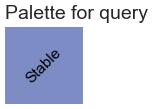

In [19]:
# Variables for the enrichment setup
m_pval = 1 
e_pval = 0.05 
correction = 'fdr'
pval_cap = 10**-15 
organism = "hsapiens"
sources = ["GO:BP", "GO:CC", "GO:MF", "KEGG", "REAC"]
background = allProteins.tolist()

enrichment_sets = {
    "Stable": most_stable_proteins,
}
query_palette = {
    "Stable": def_colors[1],
}
queries = ["Stable"]

analysis_name = "gProf_pval{}_AllSamplesStability".format(e_pval)

enrich.printParams(
    m_pval,
    e_pval,
    correction,
    pval_cap,
    organism,
    sources,
    background,
    enrichment_sets,
    analysis_name
)

plots.color_palette(
    query_palette,
    name = "query"
)

With those parameters I've run the api and saved the results in the `data/results/{notebook_name}/` folder. The full set of terms are saved as `gProf_AllSamplesStability_FullList.csv`, which includes non-significantly enriched terms for reference and a subseted version is saved also.

### Running the Enrichment Analysis

In [20]:
output_path

'./data/results/InAllSamples/'

In [21]:
# Run and Save the Enrichment Analysis
enrich.run_gprofiler(
    query = enrichment_sets,
    background = background,
    organism = organism,
    user_threshold = m_pval,
    signf_threshold = e_pval,
    correction = correction,
    sources = sources,
    pval_cap = pval_cap,
    no_evidences = False,
    no_iea = False,
    ordered = False,
    simplify_cols=False,
    save_path = output_path,
    analysis_name = "gProf_AllSamplesStability_FullList",
    verbose = True
)

print()

# Read the results
gp_res = pd.read_csv(
    os.path.join(
        output_path, 
        "gProf_AllSamplesStability_FullList.csv"
    ),
    sep=","
)

# Create a subset of the results with the p-value cutoff
subset_gp_res = gp_res[
    gp_res["p_value"] < e_pval
]

# Save the subset results
subset_gp_res.to_csv(
    f"{output_path}{analysis_name}.csv",
    sep=",",
    index=False
)

print(f"""After the p-value cutoff of {e_pval} there are total of {subset_gp_res.shape[0]} enriched terms.""")

utils.print_series(
    subset_gp_res["query"].value_counts(),
    header = f"Number of enriched terms per query with p-val cutoff {e_pval}:",
    tab = 2,
    elements_with_order = queries
)

Capping the p_value at 1e-15
P-value threshold: 1 
Correction method: fdr
Number of queries: 1
Number of terms per query:
   Stable -> 3286
Number of Unique enriched terms: 3286
Number of total terms saved: 3286
Enrichment result are prepared in 00h:00m:04s

After the p-value cutoff of 0.05 there are total of 471 enriched terms.
Number of enriched terms per query with p-val cutoff 0.05:
   Stable -> 471


I've created small data visualizations to summarize the enrichment results from a very high-level overview to a more detailed source specific overviews. Here I will be going over some of them to highlight and talk about the results we observe from the set of stable proteins' enrichment analysis.

### Summary of the Enrichment Results

#### The P-value and Enrichment Score Distributions

In this plot I create two or more subplots to highlight the distributions of two important values from the enrichment analysis. The p-value and the enrichment score. The p-value is the statistical significance of the enrichment of the term, while the enrichment score is the combined score of the term based on the p-value and the number of proteins in the term. 

There are two enrichment score calculations available in this framework:
- Gene Ratio: The ratio of the number of proteins in the set that found in the terms to the number of proteins in the term 
    - This is the default method used in the framework
    - gene_ratio = (n_in_set / n_in_term)
- Enrichment: similar to gene ratio with adjusted to the background and total number of proteins in the set
    - enrichment = (n_in_set / n_in_term) / (n_in_background / n_total)
    
Within the plot I plot p-value, gene ratio and enrichment values with the 90th, 95th, and 99th percentiles highlighted with vertical lines. 

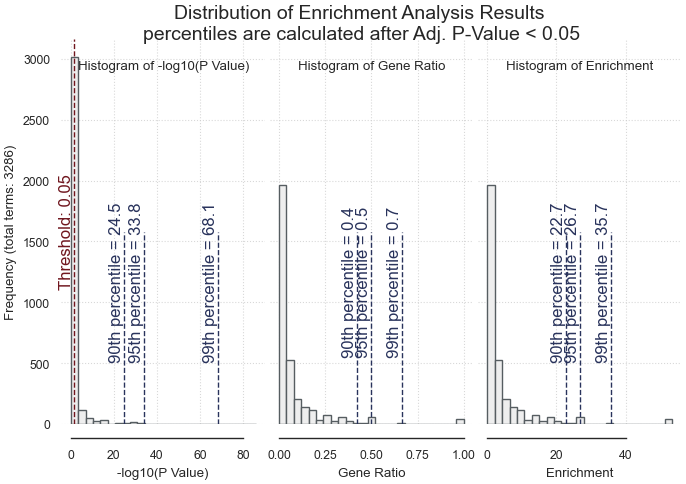

In [22]:
plots.enrich_distribution(
    data = gp_res, # The main data to plot
    subset_col = "p_value",
    subset_thr = e_pval,
    plot_cols = ["-log10(p_value)", "GeneRatio", "Enrichment"],
    annot_thr = [-np.log10(e_pval), None, None],
    figsize = (8, 5),
    horizontal = True,
    pad = 0.025,
    bins = 25,
    percentiles = [0.90, 0.95, 0.99],
    sub_titles = [ "-log10(P Value)", "Gene Ratio", "Enrichment"],
    fig_title = f"""Distribution of Enrichment Analysis Results 
percentiles are calculated after Adj. P-Value < {e_pval}""",
    save = save_to_folder,
    filename = f"{analysis_name}_combinedHistogram",
    filepath = fig_path,
    fileformat = figure_formats,
    dont_show=False
)

#### The Enriched Terms by Query and Term Source

This visualization summarizes the number of significantly enriched terms by query and term source. Since in this example we have only single query (stable) Only a single bar with stacked bars for each term source is shown. The bar is colored by the term source. 

Single query: Stable passed! Will only use this for plotting. Check if it is a mistake.


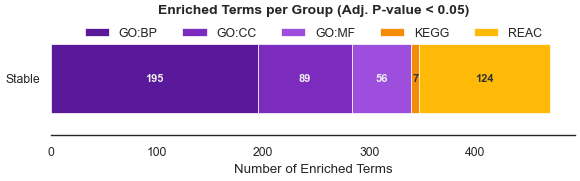

In [23]:
plots.enrich_term_counts(
    data = subset_gp_res.copy(),
    queries = queries,
    sources = sources,
    figsize=(6, 2), 
    legend_title=None,
    legend_xypos=(.5, 1.05),
    annotate = "group", 
    group_combination = "simple",
    ylabel="",
    orientation="horizontal",
    title_height=1,
    title = f"Enriched Terms per Group (Adj. P-value < {e_pval})",
    save = save_to_folder,
    filename = f"{analysis_name}_termCounts_perSimpleGroupCombinations",
    filepath = fig_path,
    fileformat = figure_formats,
    dont_show=False
)

There are 7 KEGG and 124 REACTOME terms enriched in the stable proteins.

#### Heatmap of Enrichment Results

The heatmap is used to highlight the enriched terms by query and term source. The heatmap is created with the -log10 of the p-values or one of the the enrichment scores.

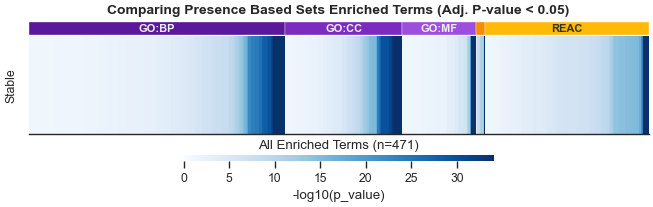

In [24]:
plots.enrich_term_grouped_heatmap(
    data = subset_gp_res.copy(),
    queries = queries,
    sources = sources,
    quant_col = "-log10(p_value)",
    figsize=(8, 2),
    min_count = 10,
    title=f"Comparing Presence Based Sets Enriched Terms (Adj. P-value < {e_pval})",
    save = save_to_folder,
    filename = f"{analysis_name}_Heatmap",
    filepath = fig_path,
    fileformat = figure_formats,
    dont_show=False
)

### Looking at the KEGG Results 

The KEGG is a database of biological pathways.  It is one of the most popular pathway databases and used in many different applications. In the manuscript I am using KEGG and Reactome to explore the biological relevance of the proteins identified as quantitatively stable and variable in different settings.

Here is all significantly enriched kegg terms in one table since they are only 7 of the.

In [25]:
kegg_data = subset_gp_res.loc[
    subset_gp_res["source"] == "KEGG", 
    [
        "native", "name", "term_size", "intersection_size", 
        "Enrichment", "GeneRatio", 
        "p_value", "p_capped",
        "-log10(p_value)", "-log10(p_capped)",
        "intersections"
    ]
].reset_index(drop=True)
# Remove KEGG root term
kegg_data = kegg_data[kegg_data["native"] != "KEGG:00000"]
# Replace "KEGG:" with hsa
kegg_data["native"] = kegg_data["native"].str.replace("KEGG:", "hsa")
kegg_prot_dict = kegg_data.set_index("name")[
    "intersections"
].str.replace("'", "").str.replace("[", "").str.replace("]", "").str.split(", ").to_dict()
kegg_data

,native,name,term_size,intersection_size,Enrichment,GeneRatio,p_value,p_capped,-log10(p_value),-log10(p_capped),intersections
0,hsa03040,Spliceosome,115,51,23.7190,0.4435,0.0000,0.0000,57.3568,15.0000,"['O15042', 'O43395', 'Q13573', 'O94906', 'Q86X..."
1,hsa03010,Ribosome,123,21,9.1314,0.1707,0.0000,0.0000,12.6174,12.6174,"['P62913', 'P62851', 'P49207', 'P62906', 'Q9Y3..."
3,hsa05171,Coronavirus disease - COVID-19,141,20,7.5864,0.1418,0.0000,0.0000,10.6751,10.6751,"['P62913', 'P62851', 'P49207', 'P62906', 'P352..."
4,hsa03015,mRNA surveillance pathway,68,13,10.2249,0.1912,0.0000,0.0000,8.3963,8.3963,"['Q9UKV3', 'Q6UN15', 'Q13148', 'Q05048', 'Q8N6..."
5,hsa03013,Nucleocytoplasmic transport,87,14,8.6066,0.1609,0.0000,0.0000,8.1292,8.1292,"['Q8WUM0', 'Q9UKV3', 'P35658', 'P57740', 'P529..."
6,hsa05014,Amyotrophic lateral sclerosis,244,15,3.2880,0.0615,0.0005,0.0005,3.2833,3.2833,"['Q8WUM0', 'P35658', 'P57740', 'P05198', 'P529..."


By far the most enriched pathway is Spliceosome, one third of the whole pathway is enriched with stable proteins.

Let's plot the proteins that are shared between these pathways using an upset plot. The upset plot is created with the `UpSetPlot` library. The plot is created with the shared proteins between the pathways and the proteins that are not shared. The plot is colored by the pathway name. The plot is sorted by the number of proteins in the pathways.

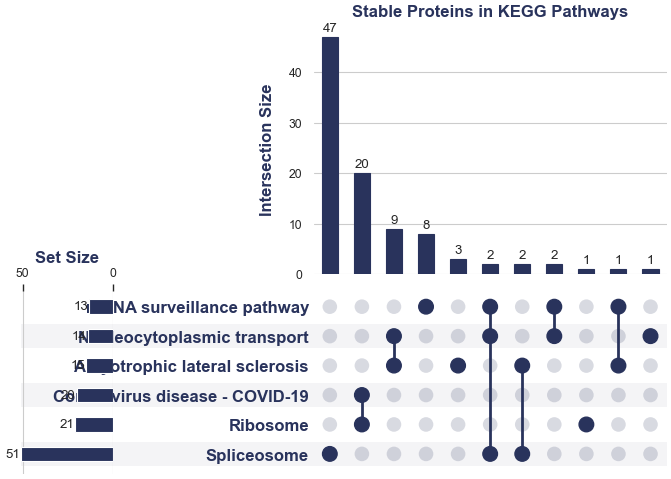

In [26]:
# Create an upset plot for the KEGG pathways
kegg_plot_data = from_contents(
    kegg_prot_dict
)

# Plot the upset plot
p = plot(
    kegg_plot_data,
    sort_by='cardinality',
    show_counts='%d',
    # min_subset_size=10, 
    facecolor=def_colors[0],
    element_size=30,
    intersection_plot_elements=8,
    totals_plot_elements=3,
)

# Set the title
p["intersections"].set_title(
    "Stable Proteins in KEGG Pathways",
    fontsize=12,
    fontweight="bold",
    color=def_colors[0],
    x=.5,
)

# Further styling
# Add intersections y-axis label
p["intersections"].set_ylabel(
    "Intersection Size",
    fontsize=12,
    labelpad=10,
    fontweight="bold",
    color=def_colors[0]
)
# Remove the spine
p["intersections"].spines["left"].set_visible(False)

# Set the yticklabel size
p["matrix"].set_yticklabels(
    p["matrix"].get_yticklabels(),
    rotation=0,
    fontsize=12, 
    fontweight="bold",  
    color=def_colors[0]
)

# Move totals x label and tick to up
p["totals"].xaxis.tick_top()
p["totals"].xaxis.set_label_position("top")
# top spine show while others are hidden
p["totals"].spines["top"].set_visible(False)
p["totals"].spines["bottom"].set_visible(False)
# Add totals x-axis label
p["totals"].set_xlabel(
    "Set Size",
    fontsize=12,
    fontweight="bold",
    color=def_colors[0],
)

plt.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "StableProteins_KEGG_UpsetPlot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

There are 47 of unique proteins from the stable set enriched in Spliceosome pathway. Let's check how many of the stable proteins are part of enriched KEGG pathways with donut plot. The donut plot is created with the number of proteins in the stable set that are enriched in KEGG pathways and the number of proteins in the stable set that are not enriched in KEGG pathways. Dark blue represents the proteins that are enriched in KEGG pathways and light blue represents the proteins that are not enriched in KEGG pathways.

Number Not in KEGG: 75
Number in KEGG: 96


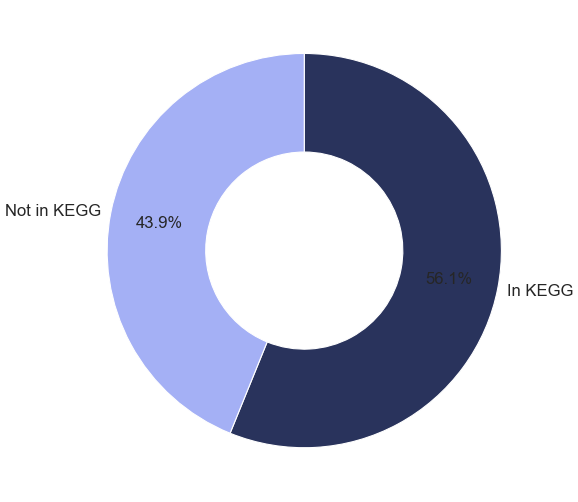

In [27]:
# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6, 6),
)
prots_in_kegg = set(kegg_plot_data["id"].tolist())
most_stable_proteins

# Pie chart for the with percentage and number of proteins
ax.pie(
    [
        len(set(most_stable_proteins).intersection(prots_in_kegg)),
        len(set(most_stable_proteins).difference(prots_in_kegg))
    ],
    labels=[
        "In KEGG",
        "Not in KEGG"
    ],
    colors=[
        def_colors[0],
        "#a4b0f5"
    ],
    autopct='%1.1f%%',
    pctdistance=0.75,
    labeldistance=1.05,
    wedgeprops=dict(width=0.5),
    textprops=dict(fontsize=12),
    startangle=90,
    counterclock=False,
    normalize=True,
)

plt.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "StableProteins_KEGG_PieChart",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

print("Number Not in KEGG:", len(set(most_stable_proteins).difference(prots_in_kegg)))
print("Number in KEGG:", len(set(most_stable_proteins).intersection(prots_in_kegg)))

More than half are found in enriched kegg pathways. And 51 of the 96 is part of spliceosome.

Additionally I want to plot the each kegg pathway as a bubble plot with on a p-value as x-axis and enrichment as the size of bubble plot.

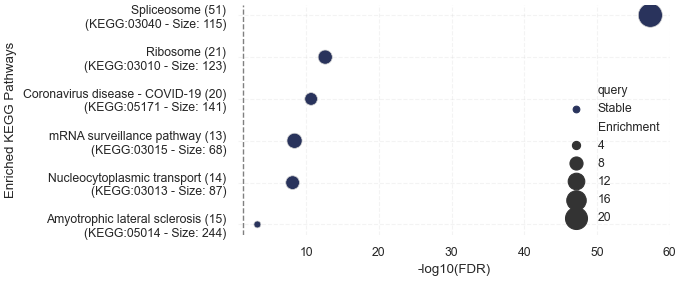

In [28]:
plot_data = subset_gp_res[
    (subset_gp_res["source"] == "KEGG") & 
    (subset_gp_res["native"]!="KEGG:00000")
].copy()

plot_data["name"]  = plot_data["name"] + " (" + plot_data["intersection_size"].astype(str)  + ")\n(" + plot_data["native"] + " - Size: " + plot_data["term_size"].astype(str) + ")"

# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(7, 3),
)

sns.scatterplot(
    ax=ax,
    data=plot_data,
    y="name",
    x="-log10(p_value)",
    hue="query",
    size="Enrichment",
    color=def_colors[0],
    edgecolor="lightgray",
    linewidth=.5,
    sizes=(25, 300),
    legend='brief',
)

# Add line at p-value cutoff
ax.axvline(
    -np.log10(e_pval),
    color="gray",
    linestyle="--",
    linewidth=1
)

# Add Styling to the plot
ax.set_xlabel("-log10(FDR)")
ax.set_ylabel("Enriched KEGG Pathways")
# Add grid
ax.grid(
    which='major', 
    color='lightgray', 
    linestyle='--', 
    alpha=0.25
)

ax.legend(
    frameon=False,
    # title="Protein Annotation",
    # loc="upper left",
    # bbox_to_anchor=(1, 1),
)

sns.despine(
    left=True,
    bottom=True
)

plt.tight_layout()

# Save the figure
if save_to_folder: 
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "EnrichedKEGGPathways",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

In [29]:
## Saving the kegg pathway results to a csv file
print("The KEGG Pathway results are saved as a csv file for supplementary table 2.6")
the_path = f"{supp_path}table_s2_6.csv"
print(f"Filepath: {the_path}")
save_data = plot_data[[
    "source", 
    "native", 
    "description",
    "term_size",
    "query_size", 
    "intersection_size",
    "GeneRatio",
    "Enrichment",
    "p_value",
    "-log10(p_value)",
    "intersections",
]]

save_data.to_csv(
    the_path,
    index=False
)

print(f"Data Shape: {save_data.shape}")
save_data.head()

The KEGG Pathway results are saved as a csv file for supplementary table 2.6
Filepath: ./data/supplementary/table_s2_6.csv
Data Shape: (6, 11)


,source,native,description,term_size,query_size,intersection_size,GeneRatio,Enrichment,p_value,-log10(p_value),intersections
12,KEGG,KEGG:03040,Spliceosome,115,157,51,0.4435,23.7190,0.0000,57.3568,"['O15042', 'O43395', 'Q13573', 'O94906', 'Q86X..."
96,KEGG,KEGG:03010,Ribosome,123,157,21,0.1707,9.1314,0.0000,12.6174,"['P62913', 'P62851', 'P49207', 'P62906', 'Q9Y3..."
107,KEGG,KEGG:05171,Coronavirus disease - COVID-19,141,157,20,0.1418,7.5864,0.0000,10.6751,"['P62913', 'P62851', 'P49207', 'P62906', 'P352..."
127,KEGG,KEGG:03015,mRNA surveillance pathway,68,157,13,0.1912,10.2249,0.0000,8.3963,"['Q9UKV3', 'Q6UN15', 'Q13148', 'Q05048', 'Q8N6..."
133,KEGG,KEGG:03013,Nucleocytoplasmic transport,87,157,14,0.1609,8.6066,0.0000,8.1292,"['Q8WUM0', 'Q9UKV3', 'P35658', 'P57740', 'P529..."


### Looking at the Reactome Results

The Reactome is a database of biological pathways. It is one of the most popular pathway databases and used in many different applications. In the manuscript I am using KEGG and Reactome to explore the biological relevance of the proteins identified as quantitatively stable and variable in different settings.

In [30]:
# Variables applied to all sections
source = "REAC"
name_col = "name"
query_col = "query"
index_col = "native"
source_col = "source"
enrichment_col = "GeneRatio"
pvalue_col = "-log10(p_value)"

number_of_clusters = 5
pick_method = "cluster"
topN = 5
sort_by = "median"
non_significant = True

# Create a subset and exploration copy of the data
subset_data = enrich.subset_by_source(
    data = subset_gp_res,
    source = source,
    source_col = source_col,
    query_col = query_col,
    # Ensure all query are there as well
    query_entries = enrichment_sets.keys(), 
    info_cols = [index_col, name_col],

    # Save a copy of the subset data for exploration
    exploration_copy = False,
    exploration_col = enrichment_col,
    # Save a copy of the subset data for reference
    subset_copy = False,
    save_path = output_path,
    analysis_name = analysis_name,
    # Verbose
    verbose = True
)

Subsetted data by source 'REAC'.
Subsetted data has 124 rows and 21 columns.
There are 124 unique terms in the subsetted data.
Subset by source completed in 00h:00m:00s


There are 124 unique terms enriched with the 0.05 fdr cutoff for the stable protein enrichment set. I will create a bubble plot to show those but their readability won't be great. 

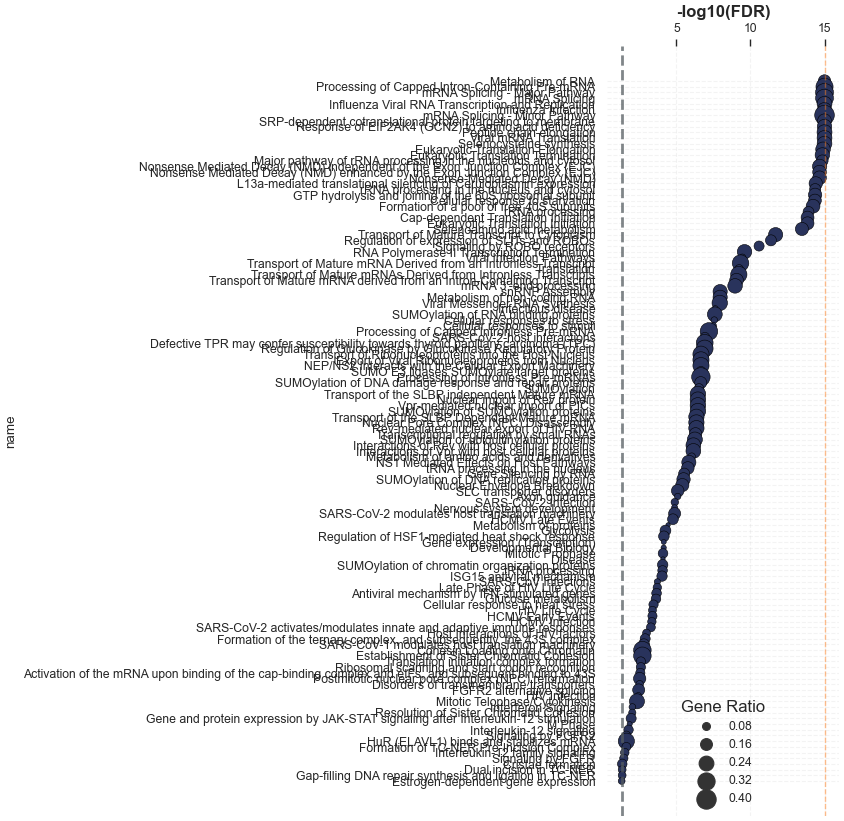

In [31]:
plot_data = subset_data.sort_values(
    ["-log10(p_capped)"], 
    ascending=False
).reset_index(drop=True)

# Initialize the figure
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (3, 10),
    # sharex = True
    # sharey = True
)

sns.scatterplot(
    data = plot_data,
    ax = ax,
    x = "-log10(p_capped)",
    y = name_col,
    # hue = "query",
    size="GeneRatio",
    sizes = (10, 200),
    edgecolor="black",
    # color=def_colors[1]
    palette=query_palette,
)

# Set line at 10e-2
ax.axvline(
    -np.log10(e_pval),
    color=def_colors[2],
    linestyle="--",
    linewidth=2,
    alpha=0.75
)

# Set p-cap line at 15
ax.axvline(
    15, 
    color=def_colors[3],
    linestyle="--",
    linewidth=1,
    alpha=0.5
)

# Enforce hard cap at 10e-15
ax.set_xlim(
    -np.log10(e_pval)-1,
    -np.log10(pval_cap)+1
)
ax.set_xlabel(
    "-log10(FDR)",
    fontsize=12,
    fontweight="bold"
)

# Add grid
ax.grid(
    which='major', 
    color='lightgray', 
    linestyle='--', 
    alpha=0.25
)

# Put the x-axis on top
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

ax.legend(
    frameon=False,
    title="Gene Ratio",
    title_fontsize=12
)
sns.despine(
    left=True,
    bottom=True
)
plt.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Stable_ReactomePathways_Scatterplot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

There are a lot of viral pathways that are likely not relevant to cancer cell lines I will ignore those and create a grouped by main-parent pathway version of this plot. 

#### Main-Pathway Grouped Faceted Scatterplot 

This plot uses a reference reactome hierarchy data that is created in one of the first notebooks. 

In [32]:
reactome_reference = pd.read_csv(
    f"{data_path}raw/ReactomeDetailed.txt", 
    sep="\t"
)
reactome_reference["Parent"] = reactome_reference["Parent"].replace(np.nan, "Top Level")
term_dict = reactome_reference.set_index("PathwayID")["Parent"].to_dict()

def recursive_find(term, term_dict):
    # If the term is not in the dictionary, it is a "Top Level" parent
    if term not in term_dict:
        return term
    # If the parent of the term is a "Top Level" parent, return the term
    elif term_dict[term] not in term_dict:
        return term
    # Otherwise, continue with the parent of the term
    else:
        return recursive_find(term_dict[term], term_dict)

plot_data = subset_data.sort_values(
    ["-log10(p_capped)"], 
    ascending=False
).copy()
plot_data = plot_data[[
    "source", 
    "name",
    "native", 
    "description",
    "term_size",
    "query_size", 
    "intersection_size",
    "GeneRatio",
    "Enrichment",
    "p_value",
    "-log10(p_value)",
    "-log10(p_capped)",
    "intersections",
]]
plot_data["native"] = plot_data["native"].str.replace("REAC:", "").str.strip()

# Identify the main parent pathway for given pathways
plot_data["Group"] = plot_data["native"].apply(
    lambda x: recursive_find(x, term_dict)
)
# # If native and Group is the same replace Group with "Top Level"
# plot_data.loc[
#     plot_data["native"] == plot_data["Group"], "Group"
# ] = "Top Level"

plot_data["Group Label"] = plot_data["Group"].map(
    reactome_reference.set_index("PathwayID")["PathwayName"]
)

plot_data["Group Label"].value_counts()

Disease                                 32
Metabolism of RNA                       25
Metabolism of proteins                  23
Cell Cycle                               9
Cellular responses to stimuli            6
Metabolism                               6
Immune System                            6
Developmental Biology                    5
Gene expression (Transcription)          4
Signal Transduction                      4
DNA Repair                               3
Organelle biogenesis and maintenance     1
Name: Group Label, dtype: int64

The disease main-pathway is the one that contains the viral pathways, I will remove those and create a new plot with the rest of the pathways. The next high count parent pathway is metabolism of RNA and then metabolism of proteins.

In [33]:
## Saving the kegg pathway results to a csv file
print("The Reactome Pathway results are saved as a csv file for supplementary table 2.7")
the_path = f"{supp_path}table_s2_7.csv"
print(f"Filepath: {the_path}")

save_data = plot_data[
    plot_data["Group Label"] != "Disease"
].drop(columns=["Group", "Group Label", "-log10(p_capped)", "name"])

save_data.to_csv(
    the_path,
    index=False
)

print(f"Data Shape: {save_data.shape}")
save_data.head()

The Reactome Pathway results are saved as a csv file for supplementary table 2.7
Filepath: ./data/supplementary/table_s2_7.csv
Data Shape: (92, 11)


,source,native,description,term_size,query_size,intersection_size,GeneRatio,Enrichment,p_value,-log10(p_value),intersections
0,REAC,R-HSA-8953854,Metabolism of RNA,617,157,109,0.1767,9.4486,0.0000,85.5716,"['O15042', 'Q14498', 'O43395', 'Q13573', 'Q082..."
1,REAC,R-HSA-72203,Processing of Capped Intron-Containing Pre-mRNA,257,157,82,0.3191,17.0650,0.0000,82.6893,"['O15042', 'Q14498', 'O43395', 'Q13573', 'Q082..."
3,REAC,R-HSA-72163,mRNA Splicing - Major Pathway,193,157,67,0.3472,18.5670,0.0000,68.4578,"['O15042', 'Q14498', 'O43395', 'Q13573', 'Q082..."
4,REAC,R-HSA-72172,mRNA Splicing,195,157,67,0.3436,18.3766,0.0000,68.2254,"['O15042', 'Q14498', 'O43395', 'Q13573', 'Q082..."
61,REAC,R-HSA-72165,mRNA Splicing - Minor Pathway,41,157,17,0.4146,22.1763,0.0000,16.9783,"['O94906', 'Q86XP3', 'O75533', 'O75643', 'Q134..."


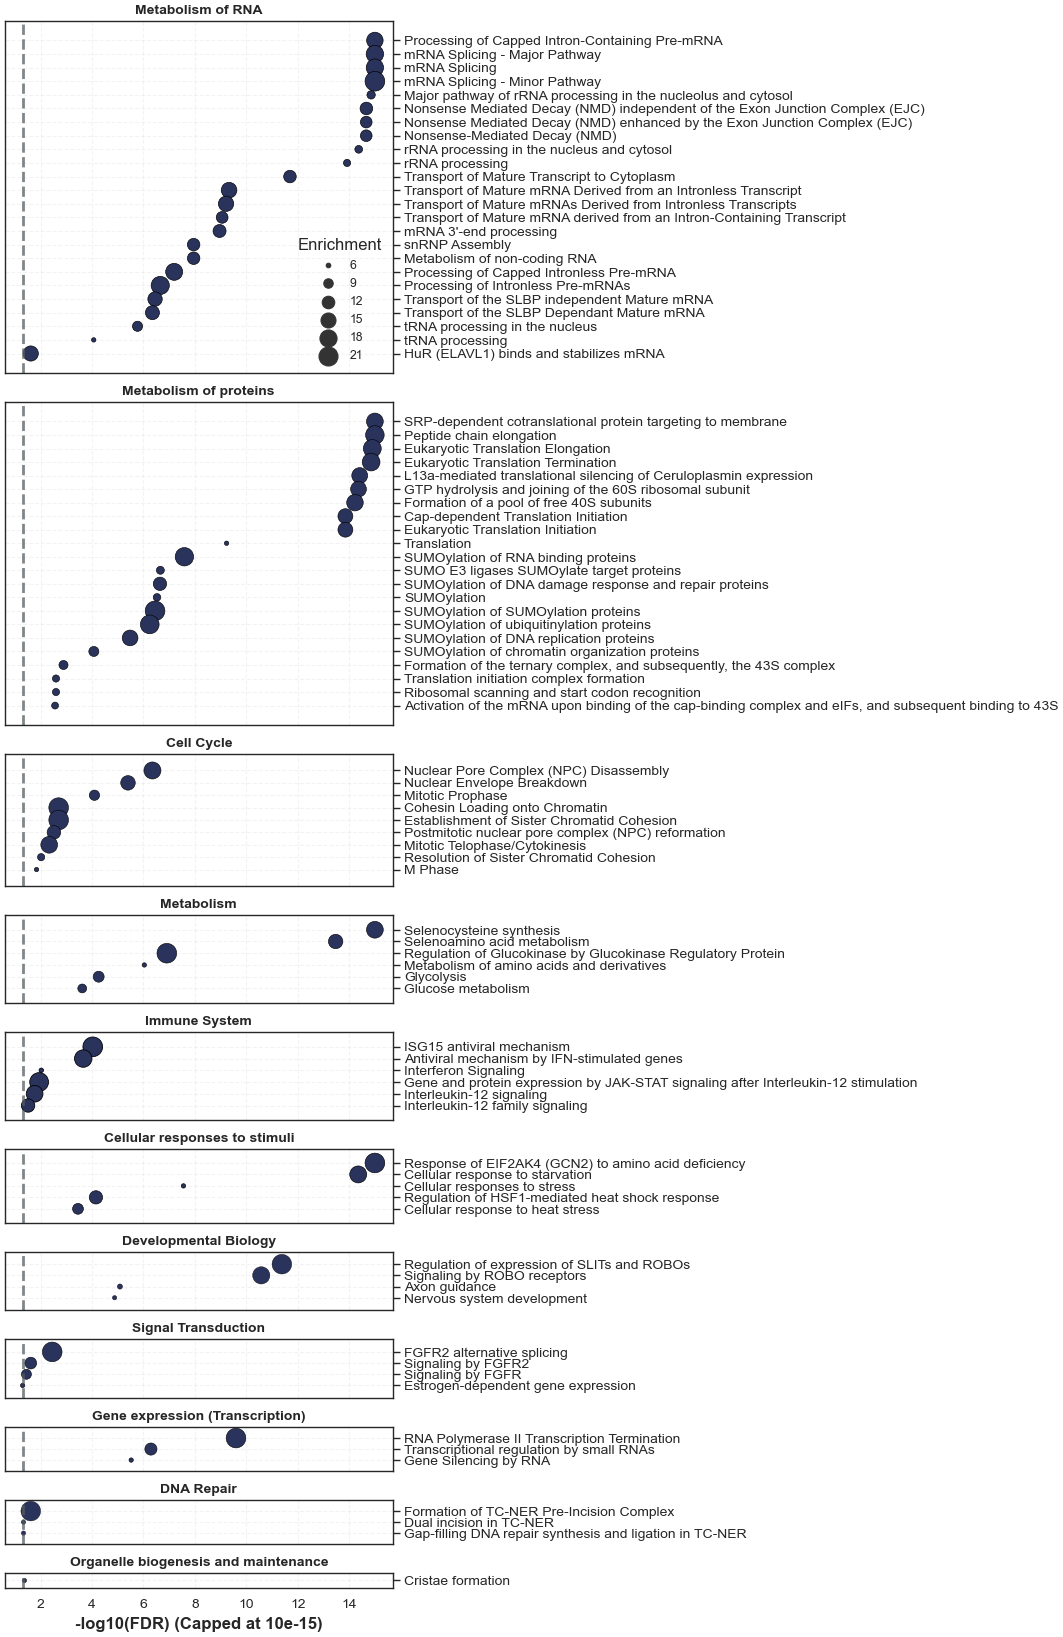

In [34]:
# Elobarate Plot

# Remove the "Disease"
plot_data = plot_data[plot_data["Group Label"] != "Disease"]
# Remove rows with native == Group
plot_data = plot_data[plot_data["native"] != plot_data["Group"]]

ngroups = plot_data["Group Label"].nunique()
grp_ratios = plot_data["Group Label"].value_counts().apply(
    # normalize to be used in height_ratios
    lambda x: x / plot_data.shape[0]
)
# Initialize the figure
fig, ax = plt.subplots(
    nrows = ngroups,
    ncols = 1,
    figsize = (5, 1.85 * ngroups),
    sharex = True,
    gridspec_kw={
        "hspace": 0.25,
        "height_ratios": grp_ratios, 
    }
)

for i, grp in enumerate(grp_ratios.index):
    cur_subset = plot_data[plot_data["Group Label"] == grp]

    sns.scatterplot(
        data = cur_subset,
        ax = ax[i],
        x = "-log10(p_capped)",
        y = name_col,
        # hue = "query",
        size="Enrichment",
        sizes = (10, 200),
        edgecolor="black",
        # color=def_colors[1]
        palette=query_palette,
    )

    # Set line at 10e-2
    ax[i].axvline(
        -np.log10(e_pval),
        color=def_colors[2],
        linestyle="--",
        linewidth=2,
        alpha=0.75
    )

    # If the axis is the first one keep the legend
    if i == 0:
        ax[i].legend(
            frameon=False,
            title="Enrichment",
            title_fontsize=12
        )
    else:
        ax[i].legend().remove()

    # Add grid
    ax[i].grid(
        which='major', 
        color='lightgray', 
        linestyle='--', 
        alpha=0.25
    )       

    # Put the y-labels on the right, while keeping ticklabels on the left
    ax[i].yaxis.tick_right()
    # set yticklabels to correctly reflect line breaks
    ax[i].set_yticklabels(
        ax[i].get_yticklabels(),
        fontsize=10,
        fontweight="normal",
        linespacing=1.5,
    )
    ax[i].set_ylabel("")

    # ax[i].yaxis.set_label_position("right")
    ax[i].set_title(
        grp,
        fontsize=10,
        fontweight="bold",
        pad=5
    )
    # add margings to y-axis
    ax[i].margins(
        # Based on the number of terms in the group
        y=(1/cur_subset.shape[0])*1.5
    )

    # if the last axis add the x-label
    if i == ngroups-1:
        ax[i].set_xlabel(
            "-log10(FDR) (Capped at 10e-15)",
            fontsize=12,
            fontweight="bold"
        )
        # Set xticklabels
        ax[i].set_xticklabels(
            ax[i].get_xticklabels(),
            fontsize=10,
            fontweight="normal"
        )
    else:
        ax[i].set_xlabel("")

plt.tight_layout()

if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Stable_ReactomePathways_Scatterplot_grouped",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

This is a more cleaner version of the reactome pathway enrichment results in one place (- the viral pathways).

# Conclusion

In this notebook I've used the `questvar`'s statistical testing summary tables and explore the quantitative stability and variability of all cancer cell lines that we used. Without any grouping or subsetting, this enabled me to see the proteins' that are more stable and variable in all comparisons. I've explored the biological processes and pathways that are enriched in both the quantitatively stable and variable proteins sets and discovered the stable-core proteome that enriched in a lot of rna and protein metabolism related pathways, while the variable proteome enriched doesn't have a particular pattern other than the their identification being driven by the comparison of cancer cell lines compared to hematopoietic cell lines. 

In [35]:
print("Notebook Execution Time:", utils.prettyTimer(utils.getTime() - nbStartTime))

Notebook Execution Time: 00h:00m:41s
